# Imports and constants

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import cv2 as cv
import json
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from math import ceil

In [2]:
# directory with the coco images
dir_ = "D:/Datasets/COCO/Images/train2014/"

# directory with the annotations bounding boxes
data_annotation_path = "D:/Datasets/COCO/Annotations/annotations/instances_train2014.json"

In [3]:
# initialize COCO api for instance annotations
coco=COCO(data_annotation_path)

loading annotations into memory...
Done (t=9.09s)
creating index...
index created!


In [4]:
# number of classes 
global num_classes_coco
num_classes_coco = max(coco.cats.keys())

In [5]:
# temporary grid size
grid_size = (10,10)

# Utils

In [43]:
def Get_images_batch_from_COCO(batch_size, coco, grid_size):
    ''' This function produces the batches for the training'''
    
    while True:
        # iamges batch
        batch = []
        batch_anns  = []
        detection_grid = []
        for i in range(batch_size):
            
            # get all images containing given categories, select one at random
            catIds = coco.getCatIds(catNms=coco.cats)

            # get all images through their IDs
            imgIds = coco.getImgIds(catIds=catIds )

            # random select an image and its annotations
            img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
            annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)

            ### load the image and the annotations ###
            image = cv.imread(os.path.join(dir_,img["file_name"]))
            # cvtColor changes the color conversion
            rgb_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            image_H = rgb_image.shape[0]
            image_W = rgb_image.shape[1]
            
            #load annotations
            anns = coco.loadAnns(annIds)

            # append the image to the batch and annotations to batch_anns
            batch.append(rgb_image)
            temp_annotations = Parse_annotations(anns,image_H,image_W)
            batch_anns.append(temp_annotations)       
            
            # build detection grid
            detection_grid.append(Build_detection_grid(temp_annotations,grid_size,(image_H,image_W),num_classes_coco))
            
        yield np.array(batch, dtype='object'), batch_anns, np.array(detection_grid, dtype='object')
        
def Parse_annotations(annotations,image_H,image_W):
    '''
    This function returns a list of lists. Each element of the main list contains the parameters of a of a bounding box:
    
    - x: center coordinate x 
    - y: center coordinate y 
    - w: width of the bounding box
    - h: height of the bounding box
    - class: class of the object inside the bounding box
    
    '''
    data = []
    for annotation in annotations:
        bbox = Rescale_BB_coordinates(annotation['bbox'],image_H,image_W)
        category_id = annotation['category_id']
        bbox.append(category_id)
        data.append(bbox)
    return data

def Rescale_BB_coordinates(data,image_H,image_W):
    '''rescale BB coordinates according to iamge dimensions:
    - output: center_x, center_y, width, height 
    - input: upper_left_x, upper_left_y, width, height'''
    data[0] = (data[0]+data[2]/2)/image_W # x
    data[1] = (data[1]+data[3]/2)/image_H # y
    data[2] = (data[2])/image_W # w 
    data[3] = (data[3])/image_H # h
    return data

def Norm2Orig(x0,y0,w,h,image_size):
    '''Changes the coordinates from the scale [0,1] to the original annotation size'''
    image_H = image_size[0] 
    image_W = image_size[1]
    center_x = int(x0*image_W)
    center_y = int(y0*image_H)
    W = int(w*image_W)
    H = int(h*image_H)
    return center_x,center_y,W,H
    
def Draw_BB(orig_image, image_datas, coco, fontscale=.7, bb_thickness=2):
    
    '''Draw bounding boxes on an image
    
    - output: copy of the original image with overlapped BB
    - input: image, annotations for the image, coco '''
    
    # copy the original image to not modify the original
    image = np.copy(orig_image)
    image_H = image.shape[0]
    image_W = image.shape[1]
    
    for image_data in image_datas:
        
        try:
            # unpack image data
            x0, y0, w, h, label_ = image_data
        except: 
            # unpack image data with boxiness
            x0, y0, w, h, boxiness,  label_ = image_data
        
        # rescale the center and dimensions of the BB
        cetnter_x,center_y,W,H = Norm2Orig(x0,y0,w,h,(image_H,image_W))
        
        # build start and stop point for bb
        start_point = (cetnter_x-int(W/2), center_y+int(H/2))
        stop_point = (cetnter_x+int(W/2), center_y-int(H/2))

        # draw the rectangle
        image = cv.rectangle(image, start_point, stop_point, color=(0,0,255), thickness=5)
        
        # draw bboxes centers
        cv.circle(image,(cetnter_x,center_y),radius=0,color=(0,0,255),thickness=10)

        # write BB class
        label = coco.cats[label_]['name']
        text_origin = start_point
        font = cv.FONT_HERSHEY_SIMPLEX 
        fontScale=fontscale
        color=(0,255,0)
        thickness=bb_thickness
        image = cv.putText(image, label, text_origin, font,  fontScale, color, thickness, cv.LINE_AA)
    
    return image
 
def Build_detection_grid(annotations,grid_size,image_size,num_classes,priors=[(1.0,1.0)]):
    '''This function builds the detection grid associated with each image:
    - input: image_size = (image_Width, image_Height)
    - output: (grid_size[0],grid_size[1],B*(5+C)) where B is the number of priors and C the number of classes 
    '''
    
    # initialize the grid
    grid_volume = (grid_size[0],grid_size[1],len(priors)*(5+num_classes))
    grid = np.zeros(grid_volume)
    
    for annotation in annotations:
        
        # unpack annotations
        x,y,w,h,label = annotation
        
        # find the Grid Cell (GC) responsible for the detection
        resp_GC_y = int(x*grid_size[0])
        resp_GC_x = int(y*grid_size[1])
        
        for prior in priors:
        
            # create labels vector
            labels = np.zeros(num_classes_coco)
            # pay attention that the correct label is equal to the position where labels==1 +1
            labels[label-1]=1

            # fill responsible Grid Cell (1:boxiness)
            grid[resp_GC_x,resp_GC_y,:5] = x,y,w,h,1
            grid[resp_GC_x,resp_GC_y,5:] = labels
    
    return grid

def Draw_grid(orig_image,grid_size):
    '''This function draws the detection grid on a copy of the original image
    
    -inputs:original image and grid sizes
    -output:copy of the original image with the grid on top
    
    '''
    
    # copy the original image to not modify the original
    image = np.copy(orig_image)
    image_H = image.shape[0]
    image_W = image.shape[1]
    
    # draw vertical lines
    for i in range(grid_size[0]):
        start = (int(image_W*i/grid_size[0]),0)
        stop = (int(image_W*i/grid_size[0]),image_H)
        cv.line(image,start,stop,(255,0,0),2,2)
        
    # draw orizontal lines
    for j in range(grid_size[1]):
        start = (0,int(image_H*j/grid_size[0]))
        stop = (image_W,int(image_H*j/grid_size[0]))
        cv.line(image,start,stop,(255,0,0),2,2)
        
    return image

def DetectionGrid2ImageDetection(detection_grid):
    
    '''This function returns an array of size (batch_size, ). Each of the batches contains a list of lists containing the bboxes
       coordinates and parameters. The output should be correctly interpreted by the DrawBBo function.
    '''
    
    def Unpack_grid(grid,detections_coord_x,detections_coord_y,i):

        # positions of detections on the grid 
        posX,posY = detections_coord_x[i],detections_coord_y[i]

        # current box parameters
        x = grid[posX,posY,0]
        y = grid[posX,posY,1]
        w = grid[posX,posY,2]
        h = grid[posX,posY,3]
        boxiness = grid[posX,posY,4]
        label = np.argmax(grid[posX,posY,5:]) + 1

        return x,y,w,h,boxiness,label
        
    bboxes = []

    for grid in detection_grid:

        #current bounding box
        current_image_bboxes = []

        # x layer
        first_layer = grid[:,:,0]
        detections_coord_x, detections_coord_y = np.where(first_layer>0)

        for i in range(len(detections_coord_x)):

            x,y,w,h,boxiness,label = Unpack_grid(grid,detections_coord_x,detections_coord_y,i)

            current_image_bboxes.append([x,y,w,h,boxiness,label])

        bboxes.append(current_image_bboxes)

    return bboxes

# Run

In [44]:
# build the generator
gen_ = Get_images_batch_from_COCO(2, coco, grid_size)

In [45]:
# get a batch
batch, anns, detection_grid = gen_.__next__()

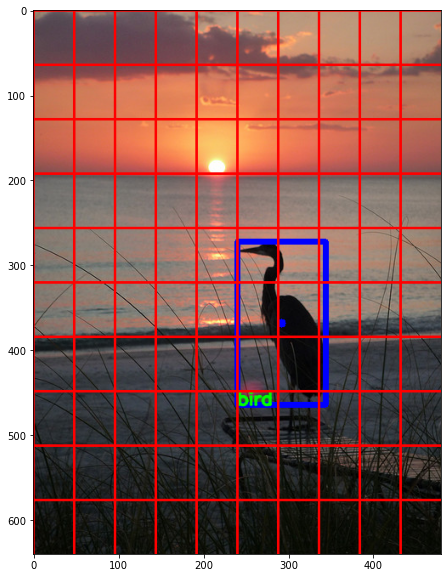

In [46]:
# Draw BBox
test_image = Draw_BB(batch[0],anns[0],coco)
test_image = Draw_grid(test_image, grid_size)
plt.figure(figsize=(10,10))
plt.imshow(test_image)

# Test wether the reconstuction of bboxes from the detection grid works

In [47]:
bboxes = DetectionGrid2ImageDetection(detection_grid)

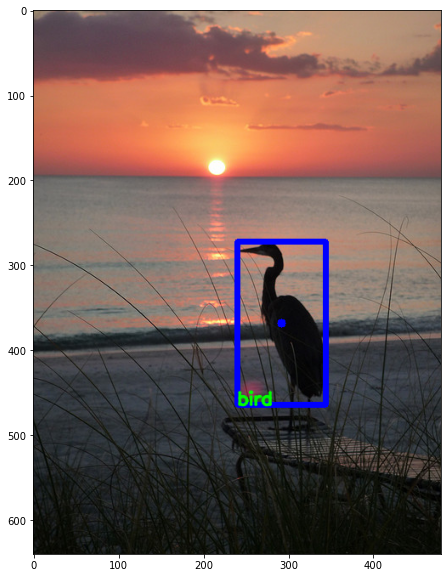

In [48]:
# Draw BBox
test_image = Draw_BB(batch[0],bboxes[0],coco)
plt.figure(figsize=(10,10))
plt.imshow(test_image)